<a href="https://colab.research.google.com/github/simami-ml/cds/blob/main/6_4_blend_stack_f.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Большой практический урок по блендингу и стэкингу.**


## Задача: "Обучи модели для блендинга и стэккинга, выбери лучшие"

**Датасеты:**
- quickstart_train.csv https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/quickstart_train.csv
- quickstart_test.csv https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/quickstart_test.csv

**Регрессионный таргет:** столбец `target_reg` , метрика `RMSE`

Для блендинга и стэккинга выбрать 3 модели:

- Любые 2 бустинга на ваш выбор
- Любую другую модель (не бустинг)

Для стэккинга в качестве метамодели желательно взять простой алгоритм (регрессию, KNN и.т.п)

Не обязательно выбирать одинаковые тройки, можно для стэккинга одни, для блэндинга другие 3. Можно использовать модели из предыдущей практики.

Далее реализуем блэндинг и стэккинг и делаем финальное предсказание:

- можно выбрать предсказание от блендинга
- можно от стэккинга
- можно ансамбль блэндинга и стэккинга
- можно блэндинг блэндинга и стэккинга с весами

**Дополнительные условия:**

Особо ничем вас не ограничиваем, можно пользоваться всем арсеналом: подбирать гиперпараметры в Optuna, генерить\отбирать признаки и.т.п. Но желательно сосредоточиться на освоении блендинга со стэккингом и подбором моделей для них.
Сохраняем в submission.csv только колонки car_id и target_reg
В конце добавляем выводы о проделанных экспериментах, что зашло - не зашло.
Желательно, чтобы на выполнение всего ноутбука уходило не более 30 мин.

**Формат сдачи:**

В текстовом поле вводим ссылки на онлайн версию jupyter ноутбука (GoogleСolab, Kaggle) с выполненным заданием, и публичную ссылку на файлхостинг (GoogleDrive, ЯндексДиск или др.) с оригиналом ноутбука. (проверяем, что они работают).
Во вложение добавляем тот же ноутбук, сохраненный в формате pdf с аутпутами всех ячеек (не более 5 Mb).
В следующем шаге отправляем получившийся CSV файл с предсказаниями.

In [ ]:
#!pip install pandas seaborn optuna xgboost lightgbm catboost termcolor ipywidgets vecstack -q

In [ ]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [ ]:
import time

import pandas as pd
import numpy as np
import seaborn as sns
import optuna

import xgboost as xgb
import lightgbm as lgb
import catboost as cb

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.cm import get_cmap

from math import sqrt
from scipy import stats

from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error,  mean_absolute_error
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from vecstack import StackingTransformer
from vecstack import stacking

from termcolor import colored

import warnings
warnings.filterwarnings("ignore")

matplotlib.style.use('ggplot')
pd.set_option('display.max_rows', None)
pd.options.mode.chained_assignment = None
optuna.logging.set_verbosity(optuna.logging.WARNING)

start_time = time.time()

## Загрузка и подготовка данных

Подгрузим и изучим данные.

In [ ]:
train = pd.read_csv(
    "https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/quickstart_train.csv")

display(train.sample())
train.info()

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,mean_rating,distance_sum,rating_min,speed_max,user_ride_quality_median,deviation_normal_count,user_uniq
269,s54993523h,Smart Coupe,economy,petrol,3.18,2015,78583,2015,58.08,another_bug,4.567989,1.918393e+07,0.1,187.0,2.897126,174,173


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2337 entries, 0 to 2336
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   car_id                    2337 non-null   object 
 1   model                     2337 non-null   object 
 2   car_type                  2337 non-null   object 
 3   fuel_type                 2337 non-null   object 
 4   car_rating                2337 non-null   float64
 5   year_to_start             2337 non-null   int64  
 6   riders                    2337 non-null   int64  
 7   year_to_work              2337 non-null   int64  
 8   target_reg                2337 non-null   float64
 9   target_class              2337 non-null   object 
 10  mean_rating               2337 non-null   float64
 11  distance_sum              2337 non-null   float64
 12  rating_min                2337 non-null   float64
 13  speed_max                 2337 non-null   float64
 14  user_rid

In [ ]:
test = pd.read_csv(
    "https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/quickstart_test.csv")

display(test.sample())
test.info()

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_class,mean_rating,distance_sum,rating_min,speed_max,user_ride_quality_median,deviation_normal_count,user_uniq
17,A22674788w,VW Polo,economy,petrol,4.4,2011,2760,2021,engine_check,4.540575,1.160652e+07,0.1,123.103636,-13.129686,174,170


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1913 entries, 0 to 1912
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   car_id                    1913 non-null   object 
 1   model                     1913 non-null   object 
 2   car_type                  1913 non-null   object 
 3   fuel_type                 1913 non-null   object 
 4   car_rating                1913 non-null   float64
 5   year_to_start             1913 non-null   int64  
 6   riders                    1913 non-null   int64  
 7   year_to_work              1913 non-null   int64  
 8   target_class              1913 non-null   object 
 9   mean_rating               1913 non-null   float64
 10  distance_sum              1913 non-null   float64
 11  rating_min                1913 non-null   float64
 12  speed_max                 1913 non-null   float64
 13  user_ride_quality_median  1913 non-null   float64
 14  deviatio

In [ ]:
train.describe()

,car_rating,year_to_start,riders,year_to_work,target_reg,mean_rating,distance_sum,rating_min,speed_max,user_ride_quality_median,deviation_normal_count,user_uniq
count,2337.000000,2337.000000,2337.000000,2337.000000,2337.000000,2337.000000,2.337000e+03,2337.000000,2337.000000,2337.000000,2337.0,2337.000000
mean,4.354292,2014.040650,63711.443731,2018.069748,44.947381,4.478831,1.356912e+07,0.138870,160.984884,-0.329339,174.0,171.624305
std,0.996954,1.685852,33755.012096,2.159484,17.647533,0.418588,4.253209e+06,0.163978,33.211161,9.581800,0.0,3.158088
min,0.980000,2011.000000,23.000000,2014.000000,17.640000,3.529885,1.478866e+06,0.000000,91.423508,-38.116345,174.0,136.000000
25%,3.740000,2013.000000,41053.000000,2016.000000,31.570000,4.155747,1.058758e+07,0.100000,123.609208,-6.141569,174.0,171.000000
50%,4.360000,2014.000000,64415.000000,2018.000000,40.010000,4.442989,1.321852e+07,0.100000,172.435742,-0.195860,174.0,172.000000
75%,5.000000,2015.000000,86515.000000,2020.000000,54.720000,4.675345,1.631788e+07,0.100000,188.597411,5.370422,174.0,173.000000
max,8.900000,2017.000000,142862.000000,2022.000000,141.130000,5.700747,3.119785e+07,1.500000,209.982840,35.770493,174.0,174.000000


In [ ]:
train.describe(include=['object'])

,car_id,model,car_type,fuel_type,target_class
count,2337,2337,2337,2337,2337
unique,2337,26,4,2,9
top,y13744087j,Hyundai Solaris,economy,petrol,engine_overheat
freq,1,161,1536,2289,289


Как уже видели в прошлых заданиях - данные без пропусков, без сильных выбросов.

Далее зафиксируем random_state, обозначим столбцы для удаления, категориальные столбцы, немного преобразуем датасеты.

In [ ]:
random_state = 73

In [ ]:
drop_cols = ['car_id', 'target_reg', 'deviation_normal_count', 'target_class']
targets = ['target_reg', 'target_class']
cat_features = ['car_type', 'fuel_type', 'model']

filtered_features = [i for i in train.columns if (i not in targets and i not in drop_cols)]
num_features = [i for i in filtered_features if i not in cat_features]

print('cat_features :', len(cat_features), cat_features)
print('num_features :', len(num_features), num_features)
print('targets', targets)

cat_features : 3 ['car_type', 'fuel_type', 'model']
num_features : 10 ['car_rating', 'year_to_start', 'riders', 'year_to_work', 'mean_rating', 'distance_sum', 'rating_min', 'speed_max', 'user_ride_quality_median', 'user_uniq']
targets ['target_reg', 'target_class']


In [ ]:
X = train.drop(drop_cols, axis=1, errors="ignore")
y = train["target_reg"]
test_df = test.drop(drop_cols, axis=1, errors="ignore")

cat_features_index = [i for i in range(X.shape[1]) if X.columns[i] in cat_features]
print('cat_features_index :', len(cat_features_index), cat_features_index)

for col in cat_features:
    X[col] = X[col].astype('category')
    test_df[col] = test_df[col].astype('category')

#X.info()
#test_df.info()

cat_features_index : 3 [0, 1, 2]


Была попытка удалить имеющиеся фичи, добавить новых фичей, после добавления новых удалить сильно коррелирующие фичи - результата это не принесло. Оставлю часть для истории.

In [ ]:
year_today = 2022
drop_cols_feat = ['year_to_start', 'year_to_work', ] #'riders', 'yts', 'ytw', 'distance_sum', 'speed_max', 'mean_riders_year']
X_feat = X.copy()
X_feat['yts'] = year_today + 1 - X_feat['year_to_work']  # годы работы в автопарке
X_feat['ytw'] = year_today + 1 - X_feat['year_to_start']  # лет эксплуатации всего

X_feat['mean_riders_year'] = X_feat['riders'] / X_feat['yts']
X_feat['mean_distance_year'] = X_feat['distance_sum'] / X_feat['yts']
X_feat['distance_riders'] = X_feat['distance_sum'] / X_feat['riders']
X_feat['distance_speed_max'] = X_feat['distance_sum'] / X_feat['speed_max']
# X_feat['distance_riders_year'] = X_feat['distance_sum']/X_feat['riders']/X_feat['yts']
# X_feat['distance_speed_max_year'] = X_feat['distance_sum']/X_feat['speed_max']/X_feat['yts']
X_feat = X_feat.drop(drop_cols_feat, axis=1)

test_feat = test.copy()
test_feat = test_feat.drop('car_id', axis=1, errors="ignore")
test_feat['yts'] = year_today+1 - test_feat['year_to_work']  # годы работы в автопарке
test_feat['ytw'] = year_today+1 - test_feat['year_to_start']  # лет эксплуатации всего

test_feat['mean_riders_year'] = test_feat['riders'] / test_feat['yts']
test_feat['mean_distance_year'] = test_feat['distance_sum'] / test_feat['yts']
test_feat['distance_riders'] = test_feat['distance_sum'] / test_feat['riders']
test_feat['distance_speed_max'] = test_feat['distance_sum'] / test_feat['speed_max']
# test_feat['distance_riders_year'] = test_feat['distance_sum']/test_feat['riders']/test_feat['yts']
# test_feat['distance_speed_max_year'] =test_feat['distance_sum']/test_feat['speed_max']/test_feat['yts']
test_feat = test_feat.drop(drop_cols_feat, axis=1)

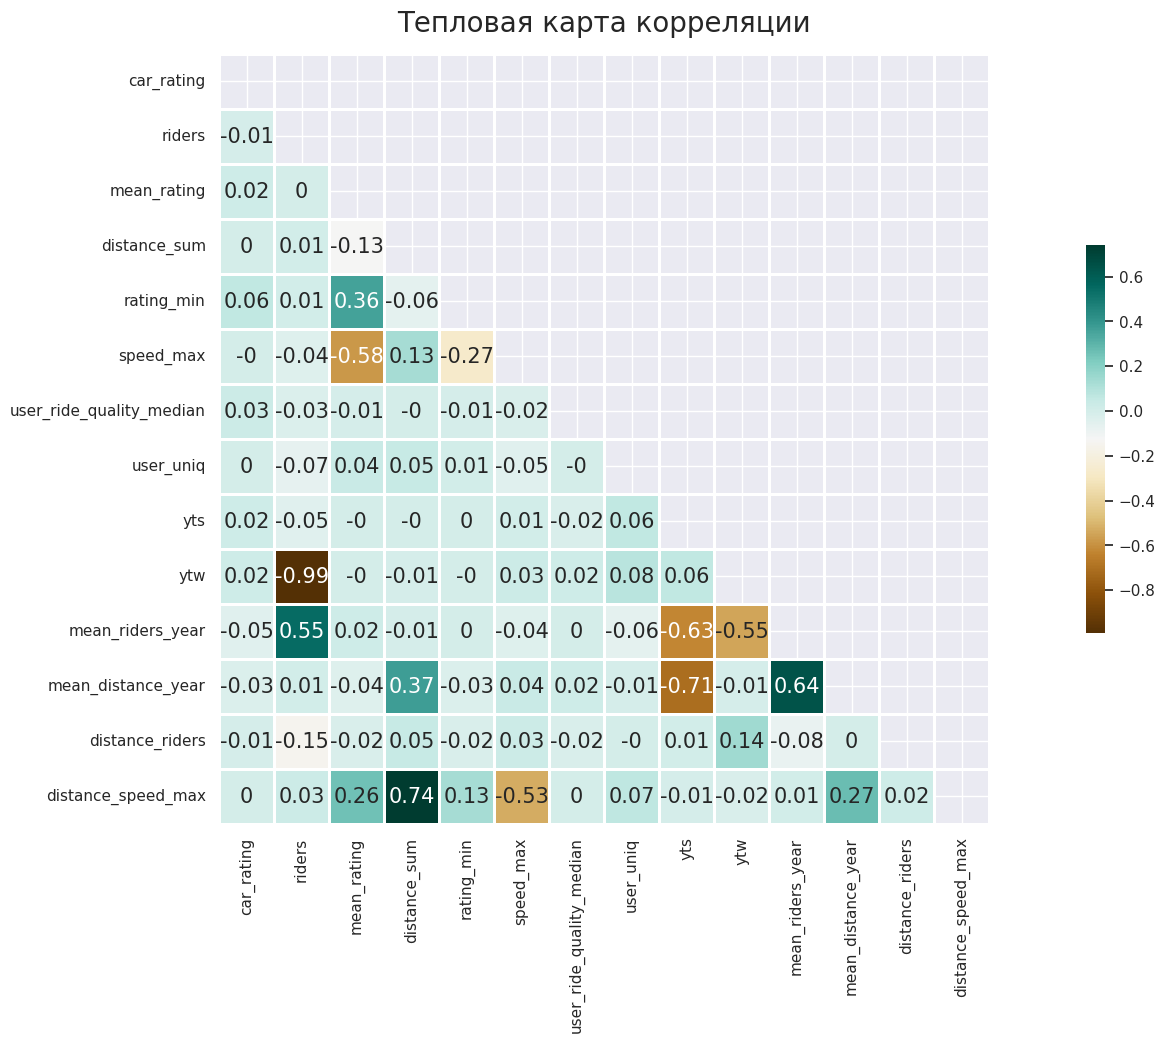

In [ ]:
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize': (25, 10)})

mask = np.triu(np.ones_like(X_feat.corr(numeric_only=True), dtype=bool))

heatmap = sns.heatmap(
    X_feat.corr(numeric_only=True).round(2),
    annot=True,
    square=True,
    cmap="BrBG",
    cbar_kws={"fraction": 0.01},
    linewidth=1,
    annot_kws={"fontsize": 15},
    mask=mask,)

heatmap.set_title(
    "Тепловая карта корреляции", fontdict={"fontsize": 20}, pad=16);

Напишем функции для подачи обучающего датасета и тестового.

In [ ]:
train_get_data = pd.read_csv(
    "https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/quickstart_train.csv")

def get_data(pool=False, le=False, matrix=False, ohe=False, full=False):
    """Получение обучающего датасета
    pool - формат для Catboost
    le - данные с LabelEncoder
    matrix - формат для XGB
    ohe - данные с OneHotEncoder
    full - возвращает полные данные без разбивки на обучающую и валидационную выборки
    """
    # train_get_data = pd.read_csv("https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/quickstart_train.csv")

    test_size = 0.2
    drop_cols = ['car_id', 'target_reg',
                 'deviation_normal_count', 'target_class']
    cat_features = ['car_type', 'fuel_type', 'model']

    X = train_get_data.drop(drop_cols, axis=1, errors="ignore")
    y = train_get_data["target_reg"].to_numpy()

    for col in cat_features:
        X[col] = X[col].astype('category')
        # test[col] = test[col].astype('category')

    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=test_size, random_state=random_state)

    if pool == True:
        train_df = cb.Pool(data=X_train, label=y_train, cat_features=cat_features)
        eval_df = cb.Pool(data=X_val, label=y_val, cat_features=cat_features)
        if full == True:
            return X, y
        else:
            return X_val, y_val, train_df, eval_df

    X_lgbm = X.copy()  # X_feat.copy()
    for col in cat_features:
        X_lgbm[col] = LabelEncoder().fit_transform(X_lgbm[col])

    if le == True:
        X_train, X_val, y_train, y_val = train_test_split(X_lgbm, y, test_size=test_size, random_state=random_state)
        if full == True:
            return X_lgbm, y
        else:
            return X_train, X_val, y_train, y_val

    if matrix == True:
        X_train, X_val, y_train, y_val = train_test_split(X_lgbm, y, test_size=test_size, random_state=random_state)
        train_df = xgb.DMatrix(X_train, label=y_train)
        eval_df = xgb.DMatrix(X_val, label=y_val)
        return X_val, y_val, train_df, eval_df

    if ohe == True:
        enc = OneHotEncoder(handle_unknown='ignore')
        enc.fit(X)
        ohe_X = enc.transform(X).toarray()
        X_train, X_val, y_train, y_val = train_test_split(ohe_X, y, test_size=test_size, random_state=random_state)
        if full == True:
            return ohe_X, y
        else:
            return X_train, X_val, y_train, y_val

    return X_train, X_val, y_train, y_val

In [ ]:
test_get_data = pd.read_csv(
    "https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/quickstart_test.csv")

def get_test_data(pool=False, le=False, matrix=False, ohe=False):
    """Получение тестового датасета
    pool - формат для Catboost
    le - данные с LabelEncoder
    matrix - формат для XGB
    ohe - данные с OneHotEncoder
    """
    # test_get_data = pd.read_csv("https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/quickstart_test.csv")

    test_to_drop = ['car_id', 'deviation_normal_count', 'target_class']
    cat_features = ['car_type', 'fuel_type', 'model']

    for col in cat_features:
        test_get_data[col] = test_get_data[col].astype('category')

    test_df = test_get_data.drop(test_to_drop, axis=1, errors="ignore")

    test_lgbm = test_df.copy()  # test_feat.copy()
    for col in cat_features:
        test_lgbm[col] = LabelEncoder().fit_transform(test_lgbm[col])

    if pool == True:
        test_df = cb.Pool(data=test_df, label=None, cat_features=cat_features)
        return test_df

    if le == True:
        return test_lgbm

    if matrix == True:
        test_xgb = xgb.DMatrix(data=test_lgbm, label=None)
        return test_xgb

    # train = pd.read_csv("https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/quickstart_train.csv")
    X = train_get_data.drop((test_to_drop+['target_reg']), axis=1, errors="ignore")
    if ohe == True:
        enc = OneHotEncoder(handle_unknown='ignore')
        enc.fit(X)
        ohe_test = enc.transform(test_df).toarray()
        return ohe_test

    return test_df

Напишем функцию для отображения параметров оптуны и зафиксируем флаг для включения оптуны.

In [ ]:
enable_optuna = False  #флаг для включения подбора параметров оптуной
visual_optuna = False  #флаг для включения визуализации работы оптуны


def optuna_info(params, study, visual=visual_optuna):

  if visual == True:
    display(optuna.visualization.plot_slice(
            study, params=params, target_name='rmse')),
    display(optuna.visualization.plot_optimization_history(study)),
    display(optuna.visualization.plot_param_importances(study))

  return print("Best trial: score {}, params {}".format(study.best_trial.value, study.best_trial.params))

Функция сохранения файла с предсказаниями


In [ ]:
def save_csv(name, save=True):
    path = 'subs/'
    if save == True:
        test[['car_id', 'target_reg']].to_csv(
            f'{path}sb_target_reg_RMSE_{name}.csv', index=False)
        print('CSV file saved!')
    pass

## Подбор моделей и гиперпараметров

### CatBoostRegressor

Подбираем гиперпараметры

In [ ]:
def fit_catboost(trial, X_val, y_val, train_dataset, eval_dataset):

    param = {"colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.82, 0.85),
             "depth": trial.suggest_int("depth", 3, 15),# ,"Plain"]),
             "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered"]),# "Bayesian", "Bernoulli", 'MVS']),
             "bootstrap_type": trial.suggest_categorical("bootstrap_type", ['No']),
             "learning_rate": trial.suggest_discrete_uniform("learning_rate", 0.1, 0.75, 0.001),
             "l2_leaf_reg": trial.suggest_discrete_uniform('l2_leaf_reg', 0, 1, 0.2),
             "min_child_samples": trial.suggest_int('min_child_samples', 1, 16),
             }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float(
            "bagging_temperature", 0, 20)

    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    cb_model = cb.CatBoostRegressor(**param,
                                    thread_count=-1,
                                    random_seed=random_state,
                                    cat_features=cat_features,
                                    eval_metric="RMSE",
                                    use_best_model=True,
                                    )

    pruning_callback = optuna.integration.CatBoostPruningCallback(trial, "RMSE")

    cb_model.fit(train_dataset,
                 eval_set=(eval_dataset),
                 verbose_eval=0,
                 plot=False,
                 early_stopping_rounds=50,
                 callbacks=[pruning_callback],
                 )

    pruning_callback.check_pruned()

    y_pred = cb_model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))

    return cb_model, y_pred

In [ ]:
def objective_cb(trial):

    X_val, y_val, train_dataset, eval_dataset = get_data(pool=True)

    model, y_pred = fit_catboost(trial, X_val, y_val, train_dataset, eval_dataset)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))

    return rmse

Фиксируем лучшие скор и параметры

In [ ]:
best_score_cb = 10.631621276271364
best_params_cb = {'colsample_bylevel': 0.825170006766161, 'depth': 12, 'boosting_type': 'Ordered',
                  'bootstrap_type': 'No', 'learning_rate': 0.555, 'l2_leaf_reg': 0.2, 'min_child_samples': 10}

if enable_optuna == True:
    study_cb = optuna.create_study(direction="minimize", pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))
    study_cb.optimize(objective_cb, n_trials=1000,
                      n_jobs=-1, show_progress_bar=True,)
    params_cb = ['l2_leaf_reg', 'colsample_bylevel',  'depth','bootstrap_type', 'boosting_type', "learning_rate", 'min_child_samples']
    optuna_info(params_cb, study_cb)

    if study_cb.best_trial.value < best_score_cb:
        print(colored('\n\n !!! переопределить параметры !!!', 'red'))

Обучаем модель

In [ ]:
# Best trial: score 10.631621276271364, params {'colsample_bylevel': 0.825170006766161, 'depth': 12, 'boosting_type': 'Ordered',
# 'bootstrap_type': 'No', 'learning_rate': 0.555, 'l2_leaf_reg': 0.2, 'min_child_samples': 10}

X_train, X_val, y_train, y_val = get_data()

cb_model = cb.CatBoostRegressor(**best_params_cb,
                                thread_count=-1,
                                random_seed=random_state,
                                cat_features=cat_features,
                                eval_metric='RMSE',
                                verbose=0
                                )

cb_model.fit(X_train, y_train,
             eval_set=(X_val, y_val),
             verbose_eval=0,
             plot=False,
             early_stopping_rounds=50
            )

rmse_cb = np.sqrt(mean_squared_error(y_val, cb_model.predict(X_val)))
rmse_cb.round(4)

10.6316

In [ ]:
# Best trial: score 10.631621276271364, params {'colsample_bylevel': 0.825170006766161, 'depth': 12, 'boosting_type': 'Ordered',
# 'bootstrap_type': 'No', 'learning_rate': 0.555, 'l2_leaf_reg': 0.2, 'min_child_samples': 10}

X_train, X_val, y_train, y_val = get_data()

cb_model = cb.CatBoostRegressor(**best_params_cb,
                                thread_count=-1,
                                random_seed=random_state,
                                cat_features=cat_features,
                                eval_metric='RMSE',
                                verbose=0  ,
                                )

cb_model.fit(X_train, y_train,
             eval_set=(X_val, y_val),
             verbose_eval=0,
             plot=False,
             early_stopping_rounds=50
            )

rmse_cb = np.sqrt(mean_squared_error(y_val, cb_model.predict(X_val)))
rmse_cb.round(4)

10.6316

In [ ]:
# отбор признаков не оказал существенного влияния на качество предсказания

# features_importances = pd.DataFrame({'features': X.columns,
#                                      'importances_value': cb_model.get_feature_importance()})
# f_im = features_importances.sort_values(by='importances_value', ascending=False).head(1500)
# display(f_im)
# filtred_features = list(f_im['features'])

Сохраняем предсказания в файл и в таблицу с тестовой выборкой

In [ ]:
test_dataset = get_test_data(pool=True)

test['target_reg'] = cb_model.predict(test_dataset)

file_suffix = 'cb'
save_csv(file_suffix)

test[f'target_reg_{file_suffix}'] = test['target_reg']

CSV file saved!


Здесь и далее указан RMSE на тесте в виде заголовка для удобства анализа в процессе решения задачи



RMSE вашего решения 11.9

### LGBMRegressor

In [ ]:
def fit_lgbm(trial, X_train, X_val, y_train, y_val):

    param = {'n_estimators': 1000,
             "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.45),
             'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
             "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-8, 10.0),
             "num_leaves": trial.suggest_int("num_leaves", 2, 100),
             "max_bin": trial.suggest_int("max_bin", 2, 100),
             "colsample_bytree": trial.suggest_float("colsample_bytree", 0.3, 0.95),
             'subsample': trial.suggest_float('subsample', 0.4, 1.0),# ["goss","gbdt", 'dart']),#, 'rf']),
             "boosting_type": trial.suggest_categorical("boosting_type", ["gbdt"]),
             'min_child_samples': trial.suggest_int('min_child_samples', 1, 100),
             }

    lgbm_model = lgb.LGBMRegressor(**param,
                                   objective="rmse",
                                   metric="rmse",
                                   n_jobs=-1,
                                   random_seed=random_state,
                                   cat_feature=[0, 1, 2],
                                   )

    pruning_callback = optuna.integration.LightGBMPruningCallback(trial, "rmse")

    lgbm_model.fit(X_train, y_train,
                   eval_set=[(X_val, y_val)],
                   eval_metric='rmse',
                   verbose=0,
                   early_stopping_rounds=50,
                   callbacks=[pruning_callback]
                   )

    y_pred = lgbm_model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))

    return lgbm_model, y_pred

In [ ]:
def objective_lgbm(trial):

    X_train, X_val, y_train, y_val = get_data(le=True)

    model, y_pred = fit_lgbm(trial, X_train, X_val, y_train, y_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))

    return rmse

In [ ]:
best_score_lgbm = 10.519709405221692
best_params_lgbm = {'learning_rate': 0.2841296744605353, 'reg_alpha': 1.100403386781878, 'reg_lambda': 1.039357602594974e-08,
                    'num_leaves': 13, 'max_bin': 42, 'colsample_bytree': 0.7792295126353044, 'subsample': 0.6213690599021252,
                    'boosting_type': 'gbdt', 'min_child_samples': 12}

if enable_optuna == True:
    study_lgbm = optuna.create_study(direction="minimize", pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))
    study_lgbm.optimize(objective_lgbm, n_trials=1000,
                        n_jobs=-1, show_progress_bar=True,)
    params_lgbm = ['reg_lambda', 'reg_alpha', 'num_leaves', 'max_bin', 'colsample_bytree',
                   'subsample', 'boosting_type', "learning_rate", 'min_child_samples']
    optuna_info(params_lgbm, study_lgbm)

    if study_lgbm.best_trial.value < best_score_lgbm:
        print(colored('\n\n !!! переопределить параметры !!!', 'red'))

In [ ]:
# Best trial: score 10.519709405221692, params {'learning_rate': 0.2841296744605353, 'reg_alpha': 1.100403386781878,
# 'reg_lambda': 1.039357602594974e-08, 'num_leaves': 13, 'max_bin': 42,
# 'colsample_bytree': 0.7792295126353044, 'subsample': 0.6213690599021252, 'boosting_type': 'gbdt', '
# min_child_samples': 12}

X_train, X_val, y_train, y_val = get_data(le=True)

lgbm_model = lgb.LGBMRegressor(**best_params_lgbm,
                               n_jobs=-1,
                               objective="rmse",
                               random_state=random_state,
                               cat_feature=cat_features_index,
                               )

lgbm_model.fit(X_train, y_train,
               eval_set=[(X_val, y_val)],
               eval_metric='rmse',
               early_stopping_rounds=50,
               verbose=0,
               )

rmse_lgbm = np.sqrt(mean_squared_error(y_val, lgbm_model.predict(X_val)))
rmse_lgbm.round(4)

10.5197

In [ ]:
test_dataset = get_test_data(le=True)

test['target_reg'] = lgbm_model.predict(test_dataset)

file_suffix = 'lgbm'
save_csv(file_suffix)

test[f'target_reg_{file_suffix}'] = test['target_reg']

CSV file saved!


RMSE вашего решения 12.1

### XGBRegressor

In [ ]:
def fit_xgboost(trial, X_val, y_val, dtrain, dval):

    param = {
        "learning_rate": trial.suggest_float("learning_rate", 0.1, 0.55),
        "min_child_weight": trial.suggest_int("min_child_weight", 10, 25),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.8, 1.),
        "max_depth": trial.suggest_int("max_depth", 3, 40),
        "max_leaves": trial.suggest_int("max_leaves", 10, 25),
        "booster": trial.suggest_categorical("booster", ["gbtree", "dart"]),
        "verbosity": 0,
        "objective": "reg:squarederror",
        "eval_metric": 'rmse',
        'tree_method': 'hist',
        'random_state': random_state,
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0),

    }

    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation-rmse")

    xgb_model = xgb.train(param,
                          dtrain,
                          evals=[(dval, "validation")],
                          callbacks=[pruning_callback],
                          verbose_eval=0,
                          )

    y_pred = xgb_model.predict(dval)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))

    return xgb_model, y_pred

In [ ]:
def objective_xgb(trial):

    X_val, y_val, dtrain, dval = get_data(matrix=True)

    model, y_pred = fit_xgboost(trial, X_val, y_val, dtrain, dval)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))

    return rmse

In [ ]:
best_score_xgb = 10.761444256008934
best_params_xgb = {'learning_rate': 0.3405594123426172, 'min_child_weight': 14, 'colsample_bytree': 0.9709952750624604,
                   'max_depth': 36, 'max_leaves': 20, 'booster': 'gbtree', 'lambda': 0.94263010788944, 'alpha': 0.4785760021961863}

if enable_optuna == True:
    study_xgb = optuna.create_study(direction="minimize", pruner=optuna.pruners.MedianPruner(n_warmup_steps=15))
    study_xgb.optimize(objective_xgb, n_trials=1000,n_jobs=-1, show_progress_bar=True,)
    params_xgb = ['learning_rate',  'min_child_weight', 'colsample_bytree','max_depth', "max_leaves", 'booster', 'lambda', 'alpha']
    optuna_info(params_xgb, study_xgb)

    if study_xgb.best_trial.value < best_score_xgb:
        print(colored('\n\n !!! переопределить параметры !!!', 'red'))

In [ ]:
# Best trial: score 10.761444256008934, params {'learning_rate': 0.3405594123426172, 'min_child_weight': 14, 'colsample_bytree': 0.9709952750624604,
# 'max_depth': 36, 'max_leaves': 20, 'booster': 'gbtree', 'lambda': 0.94263010788944, 'alpha': 0.4785760021961863}

X_train, X_val, y_train, y_val = get_data(le=True)

xgb_model = xgb.XGBRegressor(**best_params_xgb,
                             random_state=random_state,
                             tree_method='hist',
                             objective='reg:squarederror',
                             eval_metric='rmse',
                             n_jobs=-1,
                             )


xgb_model.fit(X_train, y_train,
              eval_set=[(X_val, y_val)],
              verbose=0,
              early_stopping_rounds=50
              )

rmse_xgb = np.sqrt(mean_squared_error(y_val, xgb_model.predict(X_val,
                                                               iteration_range=(0, xgb_model.best_iteration + 1))))
rmse_xgb.round(4)

11.1727

In [ ]:
test_dataset = get_test_data(le=True)

test['target_reg'] = xgb_model.predict(test_dataset, iteration_range=(0, xgb_model.best_iteration + 1))

file_suffix = 'xgb'
save_csv(file_suffix)

test[f'target_reg_{file_suffix}'] = test['target_reg']

CSV file saved!


RMSE вашего решения 12.0

### RandomForestRegressor

In [ ]:
def fit_rf(trial, X_train, X_val, y_train, y_val):

    param = {'min_samples_leaf': trial.suggest_int("min_samples_leaf", 2, 12),
             'n_estimators': trial.suggest_int("n_estimators", 10, 2000),
             'min_samples_split': trial.suggest_int("min_samples_split", 2, 12),
             'max_features': trial.suggest_categorical("max_features", ["auto", 'sqrt', 'log2']),
             "max_depth": trial.suggest_int("max_depth", 2, 12),
             }

    rf_model = RandomForestRegressor(**param,
                                     criterion='squared_error',
                                     n_jobs=-1,
                                     random_state=random_state,
                                     )

    rf_model.fit(X_train, y_train)

    y_pred = rf_model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))

    return rf_model, y_pred

In [ ]:
def objective_rf(trial):

    X_train, X_val, y_train, y_val = get_data(le=True)

    model, y_pred = fit_rf(trial,  X_train, X_val, y_train, y_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))

    return rmse

In [ ]:
best_score_rf = 11.001798555975077
best_params_rf = {'min_samples_leaf': 3, 'n_estimators': 2989, 'min_samples_split': 12, 'max_features': 'auto', 'max_depth': 8}

if enable_optuna == True:
    study_rf = optuna.create_study(direction="minimize")
    study_rf.optimize(objective_rf, n_trials=1000,
                      n_jobs=-1, show_progress_bar=True,)
    params_rf = ['min_samples_leaf', 'n_estimators', 'min_samples_split', 'max_features', "max_depth"]
    optuna_info(params_rf, study_rf)

    if study_rf.best_trial.value < best_score_rf:
        print(colored('\n\n !!! переопределить параметры !!!', 'red'))

In [ ]:
# Best trial: score 11.001798555975077, params {'min_samples_leaf': 3, 'n_estimators': 2989, 'min_samples_split': 12,
# 'max_features': 'auto', 'max_depth': 8}

X_train, X_val, y_train, y_val = get_data(le=True)

rf_model = RandomForestRegressor(**best_params_rf,
                                 criterion='squared_error',
                                 n_jobs=-1,
                                 random_state=random_state,
                                 )

rf_model.fit(X_train, y_train)

rmse_rf = np.sqrt(mean_squared_error(y_val, rf_model.predict(X_val)))
rmse_rf.round(4)

11.0018

In [ ]:
test_dataset = get_test_data(le=True)

test['target_reg'] = rf_model.predict(test_dataset)

file_suffix = 'rf'
save_csv(file_suffix)

test[f'target_reg_{file_suffix}'] = test['target_reg']

CSV file saved!


RMSE вашего решения 11.9

### LinearRegression

In [ ]:
X_train, X_val, y_train, y_val = get_data(ohe=True)

lr_model = LinearRegression(fit_intercept=False, positive=False)

lr_model.fit(X_train, y_train)

y_pred_lr = lr_model.predict(X_val)
rmse_lr = np.sqrt(mean_squared_error(y_val, y_pred_lr))
rmse_lr.round(4)

15.444

In [ ]:
ohe_test_feat = get_test_data(ohe=True)
test['target_reg'] = lr_model.predict(ohe_test_feat)

file_suffix = 'lr'
save_csv(file_suffix)

test[f'target_reg_{file_suffix}'] = test['target_reg']

CSV file saved!


RMSE вашего решения 15.8

### KNeighborsRegressor

In [ ]:
def fit_kn(trial, X_train, X_val, y_train, y_val):

    param = {"n_neighbors": trial.suggest_int("n_neighbors", 700, 800),
             "leaf_size": trial.suggest_int("leaf_size", 1, 50), # ,"distance"]),
             "weights": trial.suggest_categorical("weights", ["uniform"]),
             "algorithm": trial.suggest_categorical("algorithm", ['auto', 'ball_tree', 'kd_tree', 'brute']),
             "p": trial.suggest_int("p", 1, 2),
             }

    kn_model = KNeighborsRegressor(**param,
                                   n_jobs=-1,
                                   metric='minkowski',
                                   )

    kn_model.fit(X_train, y_train)

    y_pred = kn_model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))

    return kn_model, y_pred

In [ ]:
def objective_kn(trial):

    X_train, X_val, y_train, y_val = get_data(le=True)

    model, y_pred = fit_kn(trial,  X_train, X_val, y_train, y_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))

    return rmse

In [ ]:
best_score_kn = 16.141646215339
best_params_kn = {'n_neighbors': 794, 'leaf_size': 30, 'weights': 'uniform', 'algorithm': 'brute', 'p': 2}

if enable_optuna == True:
    study_kn = optuna.create_study(direction="minimize")
    study_kn.optimize(objective_kn, n_trials=100,
                      n_jobs=-1, show_progress_bar=True,)
    params_kn = ['n_neighbors', 'leaf_size',  'weights', 'algorithm', 'p']
    optuna_info(params_kn, study_kn)

    if study_kn.best_trial.value < best_score_kn:
        print(colored('\n\n !!! переопределить параметры !!!', 'red'))

In [ ]:
# Best trial: score 16.141646215339, params {'n_neighbors': 794, 'leaf_size': 30, 'weights': 'uniform', 'algorithm': 'brute', 'p': 2}

X_train, X_val, y_train, y_val = get_data(le=True)

kn_model = KNeighborsRegressor(**best_params_kn,
                               n_jobs=-1,
                               metric='minkowski',
                               )

kn_model.fit(X_train, y_train)

rmse_kn = np.sqrt(mean_squared_error(y_val, kn_model.predict(X_val)))
rmse_kn.round(4)

16.1416

In [ ]:
test_dataset = get_test_data(le=True)
test['target_reg'] = kn_model.predict(test_dataset)

file_suffix = 'kn'
save_csv(file_suffix)

test[f'target_reg_{file_suffix}'] = test['target_reg']

CSV file saved!


RMSE вашего решения 17.4


### DecisionTreeRegressor

In [ ]:
def fit_dt(trial, X_train, X_val, y_train, y_val):

    param = {"splitter": trial.suggest_categorical('splitter', ['best','random']),
             "max_depth": trial.suggest_int("max_depth", 1, 50),
             "min_samples_split": trial.suggest_int("min_samples_split", 2, 50),
             "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 50),
             "min_weight_fraction_leaf": trial.suggest_float("min_weight_fraction_leaf", 0, 0.5),
             "max_features": trial.suggest_int("max_features", 1, 50),
             #"max_features": trial.suggest_categorical("max_features", ['auto', 'sqrt', 'log2', 'None']),
             "max_leaf_nodes": trial.suggest_int("max_leaf_nodes", 2, 50),
             "min_impurity_decrease": trial.suggest_float("min_impurity_decrease", 0, 1),
             "ccp_alpha": trial.suggest_float("ccp_alpha", 0, 1),
             }

    dt_model = DecisionTreeRegressor(**param,
                                     criterion='squared_error',
                                     random_state=random_state,
                                   )

    dt_model.fit(X_train, y_train)

    y_pred = dt_model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))

    return dt_model, y_pred

In [ ]:
def objective_dt(trial):

    X_train, X_val, y_train, y_val = get_data(le=True)

    model, y_pred = fit_dt(trial,  X_train, X_val, y_train, y_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))

    return rmse

In [ ]:
best_score_dt = 11.132932496849305
best_params_dt = {'splitter': 'best', 'max_depth': 40, 'min_samples_split': 19, 'min_samples_leaf': 31,
                  'min_weight_fraction_leaf': 0.006610962424412083, 'max_features': 7, 'max_leaf_nodes': 10,
                  'min_impurity_decrease': 0.7359758282146736, 'ccp_alpha': 0.9210883454873952}


if enable_optuna == True:
    study_dt = optuna.create_study(direction="minimize")
    study_dt.optimize(objective_dt, n_trials=100,
                      n_jobs=-1, show_progress_bar=True,)
    params_dt = ['n_neighbors', 'leaf_size',  'weights', 'algorithm', 'p']
    optuna_info(params_dt, study_dt)

    if study_dt.best_trial.value < best_score_dt:
        print(colored('\n\n !!! переопределить параметры !!!', 'red'))

In [ ]:
# Best trial: score 11.132932496849305, params {'splitter': 'best', 'max_depth': 40, 'min_samples_split': 19, 'min_samples_leaf': 31,
#'min_weight_fraction_leaf': 0.006610962424412083, 'max_features': 7, 'max_leaf_nodes': 10,
#'min_impurity_decrease': 0.7359758282146736, 'ccp_alpha': 0.9210883454873952}

X_train, X_val, y_train, y_val = get_data(le=True)

dt_model = DecisionTreeRegressor(**best_params_dt,
                                 criterion='squared_error',
                                 random_state=random_state,
                                 )

dt_model.fit(X_train, y_train)

rmse_dt = np.sqrt(mean_squared_error(y_val, dt_model.predict(X_val)))
rmse_dt.round(4)

11.1329

In [ ]:
test_dataset = get_test_data(le=True)
test['target_reg'] = dt_model.predict(test_dataset)

file_suffix = 'dt'
save_csv(file_suffix)

test[f'target_reg_{file_suffix}'] = test['target_reg']

CSV file saved!


RMSE вашего решения 12.4

## Blending

Обучили 7 моделей, посмотрим на их скор на валидации и на тесте. Сблендим лучшие (среднее, медиана, веса), посмотрим на результат


In [ ]:
scores = pd.DataFrame()
scores['model'] = ['cb','lgbm','xgb','rf','lr','kn','dt']
scores['rmse_val'] = [rmse_cb,rmse_lgbm,rmse_xgb,rmse_rf,rmse_lr,rmse_kn,rmse_dt]
scores['rmse_test'] = [11.9,12.1,12.0,11.9,15.8,17.4,12.4]
scores['dif'] = scores['rmse_val']-scores['rmse_test']
scores.round(1).sort_values('rmse_test')

,model,rmse_val,rmse_test,dif
0,cb,10.6,11.9,-1.3
3,rf,11.0,11.9,-0.9
2,xgb,11.2,12.0,-0.8
1,lgbm,10.5,12.1,-1.6
6,dt,11.1,12.4,-1.3
4,lr,15.4,15.8,-0.4
5,kn,16.1,17.4,-1.3


### Blending среднее

In [ ]:
blend_cols = ['target_reg_cb',              #rmse 11.9
              'target_reg_lgbm',            #rmse 12.1
              #'target_reg_xgb',            #rmse 12.0
              'target_reg_rf',              #rmse 11.9
              #'target_reg_lr',             #rmse 15.8
              #'target_reg_kn',             #rmse 17.4
              #'target_reg_dt',             #rmse 12.4
            ]

test['target_reg'] = test[blend_cols].median(axis=1)

file_suffix = 'blend_m'
save_csv(file_suffix)

test[f'target_reg_{file_suffix}'] = test['target_reg']

#RMSE вашего решения 11.8 mean     blend_cols = ['target_reg_xgb', 'target_reg_cb', 'target_reg_rf']
#RMSE вашего решения 11.8 median   blend_cols = ['target_reg_lgbm', 'target_reg_cb', 'target_reg_rf']

CSV file saved!


RMSE вашего решения 11.8 median

### Blending с весами

In [ ]:
w_cb = 0.4      #rmse 11.9
w_lgbm = 0.4    #rmse 12.1
w_xgb = 0       #rmse 12.0
w_rf =  0.2     #rmse 11.9
w_lr = 0        #rmse 15.8
w_kn = 0        #rmse 17.4
w_dt = 0        #rmse 12.4

check_w = round(w_cb+w_lgbm+w_xgb+w_rf+w_lr+w_kn+w_dt, 4)
if check_w != 1.:
    print(colored("!!!проверить веса!!!", 'red'), check_w-1)
else:
    print('ok')

ok


In [ ]:
test['target_reg'] = (test['target_reg_cb'] * w_cb +
                      test['target_reg_lgbm'] * w_lgbm +
                      test['target_reg_xgb'] * w_xgb +
                      test['target_reg_rf'] * w_rf +
                      test['target_reg_lr'] * w_lr +
                      test['target_reg_kn'] * w_kn +
                      test['target_reg_dt'] * w_dt
                      )


file_suffix = 'blend_w'
save_csv(file_suffix)

test[f'target_reg_{file_suffix}'] = test['target_reg']

CSV file saved!


RMSE вашего решения 11.8 w

## Stacking

### StackingRegressor

Попробуем Pipeline и StackingRegressor.

Трансформер для предобработки данных - StandardScaler и OneHotEncoder

In [ ]:
cat_transformer_ohe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy='most_frequent')),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))])

numerical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer()),
    ("scaler", StandardScaler())
])

preprocessor_ohe = ColumnTransformer(transformers=[
    ("numerical", numerical_transformer, num_features),
    ("categorical", cat_transformer_ohe, cat_features)])

Модели для stackingа

In [ ]:
estimators = [#('lr ', make_pipeline(preprocessor_ohe,
#                                     LinearRegression(fit_intercept=False,
#                                                      positive=False))),

              ('svr', make_pipeline(preprocessor_ohe,
                                    LinearSVR(random_state=random_state,))),

#               ('rcv', make_pipeline(preprocessor_ohe,
#                                     RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1]))),

              ('dt ', DecisionTreeRegressor(**best_params_dt,
                                            criterion='squared_error',
                                            random_state=random_state,)),

              ('rf ', RandomForestRegressor(**best_params_rf,
                                            criterion='squared_error',
                                            n_jobs=-1,
                                            random_state=random_state,)),

#               ('kn ', KNeighborsRegressor(**best_params_kn,
#                                           n_jobs=-1,
#                                           metric='minkowski',)),

#               ('cb ', cb.CatBoostRegressor(**best_params_cb,
#                                            n_estimators=9,#cb_model.get_best_iteration(),
#                                            cat_features=cat_features,
#                                            thread_count=-1,
#                                            random_seed=random_state,
#                                            eval_metric='RMSE',
#                                            verbose=0,)),

              ('lgb', lgb.LGBMRegressor(**best_params_lgbm,
                                        n_estimators=lgbm_model.best_iteration_,
                                        n_jobs=-1,
                                        objective="rmse",
                                        random_state=random_state,
                                        cat_feature=cat_features_index,)),

#               ('xgb', xgb.XGBRegressor(**best_params_xgb,
#                                        n_estimators=xgb_model.best_iteration+1,
#                                        random_state=random_state,
#                                        tree_method='hist',
#                                        objective='reg:squarederror',
#                                        eval_metric='rmse',
#                                        n_jobs=-1,))
               ]


stacking_reg = StackingRegressor(estimators=estimators,
                                 final_estimator=SVR(),
#                                  final_estimator=cb.CatBoostRegressor(**best_params_cb_st,
#                                                                       thread_count=-1,
#                                                                       random_seed=random_state,
#                                                                       eval_metric='RMSE',
#                                                                       verbose=0,)
                                )

In [ ]:
X_train, X_val, y_train, y_val = get_data(le=True)

stacking_reg.fit(X_train, y_train)

print('stacking_reg rmse:', round(np.sqrt(mean_squared_error(y_val, stacking_reg.predict(X_val))), 4))

stacking_reg rmse: 10.8003


In [ ]:
corr_df = pd.DataFrame()

for model, (name, _) in zip(stacking_reg.estimators_, stacking_reg.estimators):
    preprocessed = stacking_reg.estimators[0][1].fit(X_train, y_train)
    print(name, 'rmse: ', round(
        np.sqrt(mean_squared_error(model.predict(X_val), y_val)), 4))

    corr_df[name] = model.predict(X_val)

# lr  rmse:  14.0187
# svr rmse:  13.9556
# rcv rmse:  13.9914
# dt  rmse:  11.1329
# rf  rmse:  11.0018
# kn  rmse:  16.1416
# cb  rmse:  10.9866
# lgb rmse:  10.5197
# xgb rmse:  10.7614

svr rmse:  13.9556
dt  rmse:  11.1329
rf  rmse:  11.0018
lgb rmse:  10.5197


Оставили наименее коррелирующие модели.

In [ ]:
corr_df.corr().style.background_gradient(cmap="summer")

,svr,dt,rf,lgb
svr,1.000000,0.634328,0.667317,0.681073
dt,0.634328,1.000000,0.951802,0.929865
rf,0.667317,0.951802,1.000000,0.965202
lgb,0.681073,0.929865,0.965202,1.000000


In [ ]:
test['target_reg'] = stacking_reg.predict(get_test_data(le=True))

file_suffix = 'stacking_reg'
save_csv(file_suffix)

test[f'target_reg_{file_suffix}'] = test['target_reg']

CSV file saved!


RMSE вашего решения 11.9

### Stacking GetPreds

Попробуем сделать stacking своими руками =)

Возьмем 4 ранее созданные модели получим предсказания для обучающей выборки
Далее поробуем в качестве метамодели разные модельки

In [ ]:
def GetPreds(X, y, X_test, model, n_fold=5):
    test = X_test
    model.fit(X, y)
    test_preds = model.predict(test)

    folds = KFold(n_splits=n_fold)
    preds = np.empty((0, 1), float)
    z = pd.DataFrame(data=y)

    for i, (train_indices, val_indices) in enumerate(folds.split(X, z)):
        X_train, X_test = X.iloc[train_indices], X.iloc[val_indices]
        y_train, y_test = z.iloc[train_indices], z.iloc[val_indices]

        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        preds = np.append(preds, pred)

    return preds.reshape(len(X), 1), test_preds.reshape(len(test), 1)

In [ ]:
X_train_full_stack, y_train_full_stack = get_data(le=True, full=True)
test_stack = get_test_data(le=True)

X_, y_ = get_data(pool=True, full=True)
X_train_full_stack['target_cb'],  test_stack['target_cb'] = GetPreds(X_, y_, get_test_data(),
                                                                     cb.CatBoostRegressor(**best_params_cb,
                                                                                          n_estimators=cb_model.get_best_iteration(),
                                                                                          cat_features=cat_features,
                                                                                          thread_count=-1,
                                                                                          random_seed=random_state,
                                                                                          eval_metric='RMSE',
                                                                                          verbose=0,))


X_, y_ = get_data(le=True, full=True)
X_train_full_stack['target_lgbm'],  test_stack['target_lgbm'] = GetPreds(X_, y_, get_test_data(le=True),
                                                                         lgb.LGBMRegressor(**best_params_lgbm,
                                                                                           n_estimators=lgbm_model.best_iteration_,
                                                                                           n_jobs=-1,
                                                                                           objective="rmse",
                                                                                           random_state=random_state,
                                                                                           cat_feature=cat_features_index,))

X_train_full_stack['target_rf'],  test_stack['target_rf'] = GetPreds(X_, y_, get_test_data(le=True),
                                                                     RandomForestRegressor(**best_params_rf,
                                                                                           criterion='squared_error',
                                                                                           n_jobs=-1,
                                                                                           random_state=random_state,))


X_train_full_stack['target_xgb'],  test_stack['target_xgb'] = GetPreds(X_, y_, get_test_data(le=True),
                                                                       xgb.XGBRegressor(**best_params_xgb,
                                                                                        n_estimators=xgb_model.best_iteration+1,
                                                                                        random_state=random_state,
                                                                                        tree_method='hist',
                                                                                        objective='reg:squarederror',
                                                                                        eval_metric='rmse',
                                                                                        n_jobs=-1,))



Добавим фичей помимо прогноза моделей. Среднее, медианы, разницы между прогнозными таргетами.

In [ ]:
cols_target = ['target_lgbm', 'target_rf', 'target_xgb', 'target_cb']

X_train_full_stack['target_median'] = X_train_full_stack[cols_target].median(axis=1)
X_train_full_stack['target_mean'] = X_train_full_stack[cols_target].mean(axis=1)
test_stack['target_median'] = test_stack[cols_target].median(axis=1)
test_stack['target_mean'] = test_stack[cols_target].mean(axis=1)

In [ ]:
model_names = ['lgbm', 'rf', 'xgb', 'cb']

for i in range(len(model_names)):
    for j in range(len(model_names)):

        X_train_full_stack[f'{model_names[i]}_div_{model_names[j]}'] = \
            X_train_full_stack['target_' + model_names[i]] / \
            X_train_full_stack['target_' + model_names[j]]
        X_train_full_stack[f'{model_names[i]}_dif_{model_names[j]}'] = \
            X_train_full_stack['target_' + model_names[i]] - \
            X_train_full_stack['target_' + model_names[j]]

        test_stack[f'{model_names[i]}_div_{model_names[j]}'] = test_stack['target_' +
                                                                          model_names[i]] / test_stack['target_' + model_names[j]]
        test_stack[f'{model_names[i]}_dif_{model_names[j]}'] = test_stack['target_' +
                                                                          model_names[i]] - test_stack['target_' + model_names[j]]

#### ST KNeighborsRegressor

In [ ]:
def fit_kn_st(trial, X_train, X_val, y_train, y_val):

    param = {"n_neighbors": trial.suggest_int("n_neighbors", 700, 800),
             "leaf_size": trial.suggest_int("leaf_size", 1, 50),
             "weights": trial.suggest_categorical("weights", ["uniform", "distance"]),
             "algorithm": trial.suggest_categorical("algorithm", ['auto', 'ball_tree', 'kd_tree', 'brute']),
             "p": trial.suggest_int("p", 1, 2),
             }

    kn_model = KNeighborsRegressor(**param,
                                   n_jobs=-1,
                                   metric='minkowski',
                                   )

    kn_model.fit(X_train, y_train)

    y_pred = kn_model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))

    return kn_model, y_pred

In [ ]:
def objective_kn_st(trial):

    X_train, X_val, y_train, y_val = train_test_split(X_train_full_stack,
                                                      y_train_full_stack,
                                                      test_size=0.2,
                                                      random_state=random_state)

    model, y_pred = fit_kn_st(trial,  X_train, X_val, y_train, y_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))

    return rmse

In [ ]:
best_score_kn_st = 16.141646215339
best_params_kn_st = {'n_neighbors': 794, 'leaf_size': 39, 'weights': 'uniform', 'algorithm': 'brute', 'p': 2}

if enable_optuna == True:
    study_kn_st = optuna.create_study(direction="minimize")
    study_kn_st.optimize(objective_kn_st, n_trials=100,
                         n_jobs=-1, show_progress_bar=True,)
    params_kn_st = ['n_neighbors', 'leaf_size',  'weights', 'algorithm', 'p']
    optuna_info(params_kn_st, study_kn_st, True)

    if study_kn_st.best_trial.value < best_score_kn_st:
        print(colored('\n\n !!! переопределить параметры !!!', 'red'))

In [ ]:
# Best trial: score 16.141646215339, params {'n_neighbors': 794, 'leaf_size': 39, 'weights': 'uniform', 'algorithm': 'brute', 'p': 2}
kn_model_st = KNeighborsRegressor(**best_params_kn_st,
                                  n_jobs=-1,
                                  metric='minkowski'
                                  )

kn_model_st.fit(X_train_full_stack, y_train_full_stack)

test['target_reg'] = kn_model_st.predict(test_stack)

file_suffix = 'stack_kn'
save_csv(file_suffix)

test[f'target_reg_{file_suffix}'] = test['target_reg']

CSV file saved!


RMSE вашего решения 17.4

#### ST CatBoostRegressor


In [ ]:
def fit_catboost_st(trial, X_train, X_val, y_train, y_val):

    param = {'iterations': 1000,
             "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.75),
             "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 0, 1),
             "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.7, 1),
             "depth": trial.suggest_int("depth", 1, 15), # ,"Plain"]),
             "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered"]), # ,"Bayesian", "Bernoulli", 'MVS']),
             "bootstrap_type": trial.suggest_categorical("bootstrap_type", ['No']),
             "min_child_samples": trial.suggest_int('min_child_samples', 1, 16),
             }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 20)

    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    cb_model = cb.CatBoostRegressor(**param,
                                    thread_count=-1,
                                    random_seed=random_state,
                                    cat_features=cat_features,
                                    eval_metric="RMSE",
                                    use_best_model=True,
                                    )

    pruning_callback = optuna.integration.CatBoostPruningCallback(trial, "RMSE")

    cb_model.fit(X_train, y_train,
                 eval_set=(X_val, y_val),
                 verbose=0,
                 plot=False,
                 early_stopping_rounds=50,
                 callbacks=[pruning_callback],
                 )

    pruning_callback.check_pruned()

    y_pred = cb_model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))

    return cb_model, y_pred

In [ ]:
def objective_cb_st(trial):

    X_train, X_val, y_train, y_val = train_test_split(X_train_full_stack, y_train_full_stack, test_size=0.2, random_state=random_state)

    model, y_pred = fit_catboost_st(trial, X_train, X_val, y_train, y_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))

    return rmse

In [ ]:
best_score_cb_st = 10.517113899663983
best_params_cb_st = {'learning_rate': 0.4805403885222512, 'l2_leaf_reg': 0.8402307332875907, 'colsample_bylevel': 0.7704124007360537,
                  'depth': 3, 'boosting_type': 'Ordered', 'bootstrap_type': 'No', 'min_child_samples': 6}

if enable_optuna==True:
    study_cb_st = optuna.create_study(direction="minimize", pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))
    study_cb_st.optimize(objective_cb_st, n_trials=1000, n_jobs = -1, show_progress_bar=True,)
    params_cb_st = ['l2_leaf_reg', 'colsample_bylevel',  'depth', 'bootstrap_type', 'boosting_type', "learning_rate"]#, 'min_child_samples']
    optuna_info(params_cb_st, study_cb_st)

    if study_cb_st.best_trial.value < best_score_cb_st:
        print(colored('\n\n !!! переопределить параметры !!!', 'red'))

In [ ]:
# Best trial: score 10.517113899663983, params {'learning_rate': 0.4805403885222512, 'l2_leaf_reg': 0.8402307332875907,
# 'colsample_bylevel': 0.7704124007360537, 'depth': 3, 'boosting_type': 'Ordered', 'bootstrap_type': 'No', 'min_child_samples': 6}

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full_stack, y_train_full_stack, test_size=0.2, random_state=random_state)

cb_stack = cb.CatBoostRegressor(**best_params_cb_st,
                                thread_count=-1,
                                random_seed=random_state,
                                cat_features=cat_features,
                                eval_metric='RMSE',
                                verbose=0,
                                )

cb_stack.fit(X_train,y_train,
             eval_set=(X_val,y_val),
             verbose_eval=0,
             plot=False,
             early_stopping_rounds=50,
)


test['target_reg'] = cb_stack.predict(test_stack)

file_suffix = 'stack_cb'
save_csv(file_suffix)

test[f'target_reg_{file_suffix}'] = test['target_reg']

CSV file saved!


RMSE вашего решения 12.0

#### ST LinearRegression

In [ ]:
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(X_train_full_stack)
X_train_full_stack_ohe = enc.transform(X_train_full_stack)
test_stack_ohe = enc.transform(test_stack).toarray()

In [ ]:
lr_stack = LinearRegression()

lr_stack.fit(X_train_full_stack_ohe, y_train_full_stack)

test['target_reg'] = lr_stack.predict(test_stack_ohe)

file_suffix = 'stack_lr'
save_csv(file_suffix)

test[f'target_reg_{file_suffix}'] = test['target_reg']

CSV file saved!


RMSE вашего решения 15.9

## Blending Stacking

Сведем все результаты в итоговую таблицу и попробуем сделать блендинг стекинга и блендинга.

In [ ]:
scores.loc[len(scores.index)] = ['blend_median',0,11.8,0]
scores.loc[len(scores.index)] = ['blend_w',0,11.8,0]
scores.loc[len(scores.index)] = ['vecstack',0,15.5,0]
scores.loc[len(scores.index)] = ['stacking_reg',0,11.9,0]
scores.loc[len(scores.index)] = ['stack_kn',0,17.4,0]
scores.loc[len(scores.index)] = ['stack_cb',0,12.0,0]
scores.loc[len(scores.index)] = ['stack_lr',0,15.9,0]

In [ ]:
scores.round(1).sort_values('rmse_test')

,model,rmse_val,rmse_test,dif
7,blend_median,0.0,11.8,0.0
8,blend_w,0.0,11.8,0.0
0,cb,10.6,11.9,-1.3
3,rf,11.0,11.9,-0.9
10,stacking_reg,0.0,11.9,0.0
2,xgb,11.2,12.0,-0.8
12,stack_cb,0.0,12.0,0.0
1,lgbm,10.5,12.1,-1.6
6,dt,11.1,12.4,-1.3
9,vecstack,0.0,15.5,0.0


Возьмем предсказания с лучшими rmse на тесте и посчитаем среднюю, медиану и попробуем веса.

In [ ]:
blend_cols = [#'target_reg_cb',              #rmse 11.9
              #'target_reg_lgbm',           #rmse 12.1
              #'target_reg_xgb',            #rmse 12.0
              #'target_reg_rf',              #rmse 11.9
              #'target_reg_lr',             #rmse 15.8
              #'target_reg_kn',             #rmse 17.4
              #'target_reg_dt',             #rmse 12.4
              'target_reg_blend_m',         #rmse 11.8
              'target_reg_blend_w',         #rmse 11.8
              'target_reg_stacking_reg',    #rmse 11.9
              #'target_reg_stack_cb',       #rmse 13.0
              #'target_reg_stack_kn',       #rmse 17.4
              #'target_reg_stack_lr',       #rmse 15.9
             ]


test['target_reg'] = test[blend_cols].mean(axis=1)

file_suffix = 'blend_stack_mean'
save_csv(file_suffix)

test[f'target_reg_{file_suffix}'] = test['target_reg']

CSV file saved!


RMSE вашего решения 11.7 mean

In [ ]:
blend_cols = ['target_reg_cb',              #rmse 11.9
              #'target_reg_lgbm',           #rmse 12.1
              #'target_reg_xgb',            #rmse 12.0
              'target_reg_rf',              #rmse 11.9
              #'target_reg_lr',             #rmse 15.8
              #'target_reg_kn',             #rmse 17.4
              #'target_reg_dt',             #rmse 12.4
              'target_reg_blend_m',         #rmse 11.8
              'target_reg_blend_w',         #rmse 11.8
              'target_reg_stacking_reg',    #rmse 11.9
              #'target_reg_stack_cb',       #rmse 13.0
              #'target_reg_stack_kn',       #rmse 17.4
              #'target_reg_stack_lr',       #rmse 15.9
             ]

test['target_reg'] = test[blend_cols].median(axis=1)

file_suffix = 'blend_stack_median'
save_csv(file_suffix)

test[f'target_reg_{file_suffix}'] = test['target_reg']

CSV file saved!


RMSE вашего решения 11.8 median

In [ ]:
w_cb = 0.15      #rmse 11.9
w_lgbm = 0       #rmse 12.1
w_xgb = 0        #rmse 12.0
w_rf = 0.15      #rmse 11.9
w_lr = 0         #rmse 15.8
w_kn = 0         #rmse 17.4
w_dt = 0.        #rmse 12.4
w_b_m = 0.       #rmse 11.8
w_b_w =  0       #rmse 11.8
w_s_sr = 0       #rmse 11.9
w_s_cb = 0       #rmse 13.0
w_s_kn =  0      #rmse 17.4
w_s_lr =  0      #rmse 15.9
w_b_s_mn = 0.4   #rmse 11.7
w_b_s_md = 0.3   #rmse 11.8

check_w = round(w_cb+w_lgbm+w_xgb+w_rf+w_lr+w_kn+w_dt+w_b_m+w_b_w+w_s_sr+w_s_cb+w_s_kn+w_s_lr+w_b_s_mn+w_b_s_md, 4)

if check_w != 1.:
    print("!!!проверить веса!!!", check_w-1)
else:
    print('ok')

ok


In [ ]:
test['target_reg'] = (test['target_reg_cb'] * w_cb +
                      test['target_reg_lgbm'] * w_lgbm +
                      test['target_reg_xgb'] * w_xgb +
                      test['target_reg_rf'] * w_rf +
                      test['target_reg_lr'] * w_lr +
                      test['target_reg_kn'] * w_kn +
                      test['target_reg_dt'] * w_dt +
                      test['target_reg_blend_m'] * w_b_m +
                      test['target_reg_blend_w'] * w_b_w +
                      test['target_reg_stacking_reg'] * w_s_sr +
                      test['target_reg_stack_cb'] * w_s_cb +
                      test['target_reg_stack_kn'] * w_s_kn +
                      test['target_reg_stack_lr'] * w_s_lr +
                      test['target_reg_blend_stack_mean'] * w_b_s_mn +
                      test['target_reg_blend_stack_median'] * w_b_s_md
                      )

file_suffix = 'blend_stack_w'
save_csv(file_suffix)

test[f'target_reg_{file_suffix}'] = test['target_reg']

CSV file saved!


RMSE вашего решения 11.7 w

## Выводы

Дополним итоговую таблицу и сделаем выводы.

In [ ]:
scores.loc[len(scores.index)] = ['blend_stack_mean',0,11.7,0]
scores.loc[len(scores.index)] = ['blend_stack_median',0,11.8,0]
scores.loc[len(scores.index)] = ['blend_stack_w',0,11.7,0]

In [ ]:
scores.round(1).sort_values('rmse_test').head(10)

,model,rmse_val,rmse_test,dif
16,blend_stack_w,0.0,11.7,0.0
14,blend_stack_mean,0.0,11.7,0.0
15,blend_stack_median,0.0,11.8,0.0
7,blend_median,0.0,11.8,0.0
8,blend_w,0.0,11.8,0.0
3,rf,11.0,11.9,-0.9
10,stacking_reg,0.0,11.9,0.0
0,cb,10.6,11.9,-1.3
2,xgb,11.2,12.0,-0.8
12,stack_cb,0.0,12.0,0.0


In [ ]:
end_time = time.time() - start_time
print(f'Время отработки ноутбука {round((end_time)/60, 2)} минут')

Время отработки ноутбука 5.98 минут


Итого:

- обучили 7 разных моделей с подбором гиперпараметров оптуной (лучшие из них на тесте оказались `randomforest и catboost`) --- **RMSE 11.9**
- медиана (`xgb, catboost, randomforest`), среднее и веса (`lgbm , catboost, randomforest`) дали лучший результат, чем модели по отдельности --- **RMSE 11.8**
(что уже позволило преодолеть порог в 11.85)
- попробовали StackingRegressor с моделями `linearSVR, decisiontree, randomforest, lgbm` с метамоделью SVR --- **RMSE 11.9**
- попробовали вручную стекинг с разными метамоделями (`kneighbors, catboost, linearregression`) - лучший скор оказался у стекинга с метамоделью catboost --- **RMSE 11.9**
- далее сделали блендинг блендинга и стекинга --- **RMSE 11.7**, средняя между
    - медианой моделей `catboost, lgbm,  randomforest`
    - стекингом `linearSVR, decisiontree, randomforest,lgbm` с метамоделью SVR
- также если блендить блендинг и стекинг из предыдущего пункта подбором весов, тоже можно получить --- **RMSE 11.7**

В этом задании совершенно не зашли: генерация фичей, удаление фичей и удаление неважных признаков - существенного влияния на скор не замечено.

В целом, было интересно поэкспериментировать.

